### Importación de librerías

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
import gc
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Lectura del archivo excel con la información de los clientes

In [6]:
df_tabla_final = pd.read_excel("archivos_entrada_script/tabla_final.xlsx", sheet_name="Hoja2", dtype={"CODIGOCLIE":str})
df_tabla_final["CODIGOCLIE"] = df_tabla_final["CODIGOCLIE"].astype("string")
df_tabla_final = df_tabla_final.iloc[:,2:6]
df_tabla_final

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1401867926,1100.0
1,CONFITECA,C1073.21,1490000744,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,1490000688,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,1490001175,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,1490000515,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1410020880,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,1490000693,1.0
211,INTEXDECOR S.A.,G4641.11,1490001644,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,1410062892,1100.0


In [7]:
clientes_unicos = df_tabla_final["CODIGOCLIE"].unique()
print(clientes_unicos)

<StringArray>
['1401867926', '1490000744', '1490000688', '1490001175', '1490000515',
 '1401337167', '1490002225', '1401582655', '1490001247', '1401282968',
 ...
 '1401229975', '1401954998', '1490000719', '1401940609', '1410026628',
 '1410020880', '1490000693', '1490001644', '1410062892', '1490002155']
Length: 214, dtype: string


In [32]:
def intentar_abrir_archivo_datos(path_archivo):

    df_archivo_telem_tab = pd.DataFrame([1,2,3], columns=["prueba"])
    df_archivo_telem_pc = pd.DataFrame([1,2,3], columns=["prueba"])
    df_archivo_telem_c = pd.DataFrame([1,2,3], columns=["prueba"])

    # Intentar leer el archivo con separador 'tab'
    try:
        #print("Leyendo con tab")
        df_archivo_telem_tab = pd.read_csv(path_archivo,
                                            sep="\t",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            ) 
    except:
        pass

    # Intentar leer el archivo con separador 'punto y coma'
    try:
        #print("Leyendo con ;")
        df_archivo_telem_pc = pd.read_csv(path_archivo,
                                            sep=";",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass

    # Intentar leer el archivo con separador 'coma'
    try:
        #print("Leyendo con ,")
        df_archivo_telem_c = pd.read_csv(path_archivo,
                                            sep=",",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass



    if len(df_archivo_telem_tab.columns) > 1:
        df_archivo_telem = df_archivo_telem_tab.copy()
    elif len(df_archivo_telem_pc.columns) > 1:
        df_archivo_telem = df_archivo_telem_pc.copy()
    else:
        df_archivo_telem = df_archivo_telem_c.copy()

    return df_archivo_telem

### 1. Extracción de los archivos de cada grupo de clientes

#### 1.1 Extracción de los archivos con las mediciones mensuales del primer grupo de clientes

Estos clientes están clasificados por CUEN, y el formato de sus archivos varían, el procedimiento a seguir será:
1. Iterar sobre cada código de cliente
2. Buscar sus archivos de datos mensuales
3. Unificar todos en un solo archivo
4. El identificador a usar es el código de cliente

In [90]:
mediciones_clientes_g1 = r"mediciones_originales/mediciones_por_mes_g1"
archivos_mediciones_g1 = list(os.scandir(mediciones_clientes_g1))
columnas_extraer_g1 = ["Fecha","Demanda activa DEL","Demanda reactiva DEL"]

In [91]:
clientes_unicos_g1 = set()

for medicion in archivos_mediciones_g1:
    cliente = medicion.name.split('-')[1]
    clientes_unicos_g1.add(cliente)

print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(clientes_unicos_g1)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 314


In [85]:
# Iterar sobre cada cliente
for cliente in tqdm(clientes_unicos_g1, desc="Procesando clientes del grupo 01"):
    datos_cliente = []

    # Iterar sobre cada archivo de medicion del grupo 01
    for medicion in archivos_mediciones_g1:
        if cliente == medicion.name.split("-")[1]:
            df_cliente = intentar_abrir_archivo_datos(f"{mediciones_clientes_g1}/{medicion.name}")
            datos_cliente.extend(df_cliente[columnas_extraer_g1].values)

    df_datos_anual_cliente = pd.DataFrame(datos_cliente, columns=columnas_extraer_g1)
    df_datos_anual_cliente.to_csv(f"mediciones_por_anio/g1_perfil_carga_anual-{cliente}-2023.csv", index=False)

Procesando clientes del grupo 01:   0%|          | 0/314 [00:00<?, ?it/s]

Procesando clientes del grupo 01: 100%|██████████| 314/314 [01:34<00:00,  3.32it/s]


#### 1.2 Extracción de los archivos con las mediciones mensuales del segundo grupo de clientes

De estos clientes tenemos carpetas con sus mediciones por mes, no existe tabla de excel inicial, se procederá a realizar lo siguiente:
1. Iterar sobre cada carpeta (cliente)
2. Obtener los datos de sus 12 meses
3. Unificar en un único archivo anual
4. Se usará el nombre del cliente como identificador

In [114]:
mediciones_clientes_g2 = "mediciones_originales/mediciones_por_mes_g2"
archivos_mediciones_g2 = list(os.scandir(mediciones_clientes_g2))
columnas_extraer_g2 = ["Fecha", "SE (KVah)"]

In [115]:
print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(archivos_mediciones_g2)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 75


In [ ]:
# Iterar sobre cada cliente
for archivos_cliente in tqdm(archivos_mediciones_g2, desc="Procesando clientes del grupo 02"):
    nombre_cli = archivos_cliente.name
    df_concat = pd.DataFrame()

    # Obtener los archivos de las mediciones mensuales del cliente
    mediciones_mensuales_cliente = os.scandir(rf"{mediciones_clientes_g2}/{nombre_cli}")

    for medicion in mediciones_mensuales_cliente:
        medicion_mensual = pd.read_csv(rf"{mediciones_clientes_g2}/{nombre_cli}/{medicion.name}", sep=";", skiprows=2, encoding='ISO-8859-1')
        medicion_mensual = medicion_mensual[columnas_extraer_g2]
        df_concat = pd.concat([df_concat, medicion_mensual])

    df_concat.to_csv(rf"mediciones_por_anio/g2_perfil_carga_anual-{nombre_cli}-2023.csv", index=False)

Procesando clientes del grupo 02: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s]


### 2. Preprocesamiento de los datos

Ahora tenemos todos los datos unificados anualmente por cada cliente, tenemos que limpiar y preprocesar, realizar las siguientes tareas:
1. Calcular la potencia aparente (resultado de aplicar teorema pitágoras sobre potencia activa y reactiva)
2. Separar la columna 'fecha' en dos columnas 'fecha' y 'hora', fecha va a tener formato 'año/mes/dia' y hora el formato 'hh:mm'
3. Excluir aquellos registros que correspondan a fechas de sábado, domingo o días de feriado nacional
4. Normalizar los datos para que todos estén en la misma escala

In [127]:
feriados_nacionales = ["2/7/2023", "20/2/2023", "21/2/2023", "7/4/2023", "1/5/2023", \
                       "26/5/2023", "11/8/2023", "9/10/2023", "2/10/2023", "3/10/2023", "25/12/2023"]
feriados_nacionales = pd.to_datetime(feriados_nacionales, format='%d/%m/%Y')

dict_meses = {"01": "Enero",
              "02": "Febrero",
              "03": "Marzo",
              "04": "Abril",
              "05": "Mayo",
              "06": "Junio",
              "07": "Julio",
              "08": "Agosto",
              "09": "Septiembre",
              "10": "Octubre",
              "11": "Noviembre",
              "12": "Diciembre"}

print(list(dict_meses.keys()))
print(feriados_nacionales)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
DatetimeIndex(['2023-07-02', '2023-02-20', '2023-02-21', '2023-04-07',
               '2023-05-01', '2023-05-26', '2023-08-11', '2023-10-09',
               '2023-10-02', '2023-10-03', '2023-12-25'],
              dtype='datetime64[ns]', freq=None)


In [188]:
def fecha_formato_unico(fecha_str):

    # Poner separador único el '/' y año únicamente 2023
    fecha_str = fecha_str.replace('-','/').replace('2024','2023')

    if len(fecha_str.split('/')[0]) == 4: # Cuando el formato es año/mes/día
        return fecha_str
    elif len(fecha_str.split('/')[0]) != 4: # Cuando el formato es día/mes/año
        seps = fecha_str.split('/')
        return f"{seps[-1]}/{seps[1]}/{seps[0]}"
    

def recortar_valores_atipicos(df, columna_valor):
    # Calcular los cuartiles y el IQR
    Q1 = df[columna_valor].quantile(0.25)
    Q3 = df[columna_valor].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites superior e inferior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Aplicar el recorte
    df[columna_valor] = df[columna_valor].clip(lower=limite_inferior, upper=limite_superior)

In [179]:
mediciones_anuales_clientes = "mediciones_por_anio"
archivos_mediciones_anuales = list(os.scandir(mediciones_anuales_clientes))

2.1 - Transformación columna fecha archivos anuales grupo 01

In [211]:
for archivo in tqdm(archivos_mediciones_anuales, desc="Procesando archivos con mediciones anuales"):

    if archivo.name.startswith("g1"):

        # Leer el archivo con las mediciones de todo el año
        df_archivo_g1 = pd.read_csv(f"{mediciones_anuales_clientes}/{archivo.name}")

        # Transformar columna fecha a cadena
        df_archivo_g1["Fecha"] = df_archivo_g1["Fecha"].astype("string")

        # Eliminar los valores nulos en la columna 'Fecha'
        df_archivo_g1 = df_archivo_g1.dropna(subset="Fecha")

        # Separar para obtener columna Hora
        df_archivo_g1["Hora"] = df_archivo_g1["Fecha"].apply(lambda x: x.split()[1].strip())

        # Separar para obtener columna Fecha
        df_archivo_g1["Fecha"] = df_archivo_g1["Fecha"].apply(lambda x: x.split()[0].strip())

        # Transformar la columna Fecha a un formato único
        df_archivo_g1["Fecha"] = df_archivo_g1["Fecha"].apply(fecha_formato_unico)

        # Debido a que a veces se ponen datos del 2024 para reemplazar los faltantes del 2023
        # debemos descartar la fecha 29 de febrero, pues en 2023 no existe
        df_archivo_g1 = df_archivo_g1[df_archivo_g1["Fecha"] != "2023/02/29"]
        
        # Eliminar duplicados y conservar el original del 2023
        df_archivo_g1["Fecha-Hora"] = df_archivo_g1["Fecha"] + " " + df_archivo_g1["Hora"]
        df_archivo_g1 = df_archivo_g1.drop_duplicates(subset="Fecha-Hora", keep="first")

        # Transformar columna Fecha a datetime
        df_archivo_g1["Fecha"] = pd.to_datetime(df_archivo_g1["Fecha"], format='%Y/%m/%d')

        # Obtener la potencia aparente
        df_archivo_g1["Potencia_aparente"] = np.sqrt((df_archivo_g1["Demanda activa DEL"]**2) + (df_archivo_g1["Demanda reactiva DEL"]**2))

        # Eliminar días feriados y días de fin de semana
        df_archivo_g1 = df_archivo_g1[~df_archivo_g1['Fecha'].isin(feriados_nacionales) & ~df_archivo_g1['Fecha'].dt.weekday.isin([5, 6])]
        
        # Recortar valores atípicos
        recortar_valores_atipicos(df_archivo_g1, "Potencia_aparente")

        # Interpolar valores nulos usando una función polinomial
        df_archivo_g1["Potencia_aparente"] = df_archivo_g1["Potencia_aparente"].interpolate(method='polynomial', order=3)

        # Conservar solo las columnas de interés
        df_archivo_g1 = df_archivo_g1[["Fecha", "Hora", "Potencia_aparente"]]

        # Escalar la potencia
        df_archivo_g1["Potencia_aparente_escalada"] = mmscaler.fit_transform(df_archivo_g1[["Potencia_aparente"]])

        # Guardar los nuevos archivos en otra carpeta
        df_archivo_g1.to_csv(f"mediciones_por_anio_limpias/perfil_carga_anual_limpio-{archivo.name.split('-')[1]}-2023.csv", index=False)

Procesando archivos con mediciones anuales: 100%|██████████| 388/388 [00:46<00:00,  8.31it/s]


2.2 - Transformación columna fecha archivos anuales grupo 02

In [212]:
for archivo in tqdm(archivos_mediciones_anuales, desc="Procesando archivos con mediciones anuales"):

    if archivo.name.startswith("g2"):

        # Leer el archivo con las mediciones de todo el año
        df_archivo_g2 = pd.read_csv(f"{mediciones_anuales_clientes}/{archivo.name}")

        # Transformar columna fecha a cadena
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].astype("string")

        # Eliminar registros que contienen el total
        df_archivo_g2 = df_archivo_g2[~df_archivo_g2["Fecha"].str.contains("Total")]

        # Eliminar los valores nulos en la columna 'Fecha'
        df_archivo_g2 = df_archivo_g2.dropna(subset="Fecha")

        # Separar para obtener columna Hora
        df_archivo_g2["Hora"] = df_archivo_g2["Fecha"].apply(lambda x: x.split()[1].strip())

        # Separar para obtener columna Fecha
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].apply(lambda x: x.split()[0].strip())

        # Eliminar duplicados y conservar el original del 2023
        df_archivo_g2["Fecha-Hora"] = df_archivo_g2["Fecha"] + " " + df_archivo_g2["Hora"]
        df_archivo_g2["Fecha-Hora"] = pd.to_datetime(df_archivo_g2["Fecha-Hora"], yearfirst=True)
        df_archivo_g2 = df_archivo_g2.drop_duplicates(subset="Fecha-Hora", keep="first")

        # Restar un timedelta de 15 a todas las fechas (Solo en este caso por que la ultima fecha)
        # se pasa al siguiente mes
        df_archivo_g2["Fecha-Hora"] = df_archivo_g2["Fecha-Hora"] - pd.Timedelta(minutes=15)

        # Separar nuevamente para obtener columna Hora
        df_archivo_g2["Hora"] = df_archivo_g2["Fecha-Hora"].astype("string").apply(lambda x: x.split()[1][:-3].strip())

        # Separar nuevamente para obtener columna Fecha
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha-Hora"].astype("string").apply(lambda x: x.split()[0].strip())

        # Transformar la columna Fecha a un formato único
        df_archivo_g2["Fecha"] = df_archivo_g2["Fecha"].apply(fecha_formato_unico)

        # Debido a que a veces se ponen datos del 2024 para reemplazar los faltantes del 2023
        # debemos descartar la fecha 29 de febrero, pues en 2023 no existe
        df_archivo_g2 = df_archivo_g2[df_archivo_g2["Fecha"] != "2023/02/29"]

        # Transformar columna Fecha a datetime
        df_archivo_g2["Fecha"] = pd.to_datetime(df_archivo_g2["Fecha"], format='%Y/%m/%d')

        # Limpiar la columna 'SE (KVah)'
        df_archivo_g2["SE (KVah)"] = df_archivo_g2["SE (KVah)"].astype("string").str.replace(",", "").replace('"','')
        df_archivo_g2["SE (KVah)"] = df_archivo_g2["SE (KVah)"].astype("float")

        # Obtener la potencia aparente
        df_archivo_g2["Potencia_aparente"] = df_archivo_g2["SE (KVah)"] * 4

        # Eliminar días feriados y días de fin de semana
        df_archivo_g2 = df_archivo_g2[~df_archivo_g2['Fecha'].isin(feriados_nacionales) & ~df_archivo_g2['Fecha'].dt.weekday.isin([5, 6])]
        
        # Recortar valores atípicos
        recortar_valores_atipicos(df_archivo_g2, "Potencia_aparente")

        # Interpolar valores nulos usando una función polinomial
        df_archivo_g2["Potencia_aparente"] = df_archivo_g2["Potencia_aparente"].interpolate(method='polynomial', order=3)

        # Conservar solo las columnas de interés
        df_archivo_g2 = df_archivo_g2[["Fecha", "Hora", "Potencia_aparente"]]

        # Escalar la potencia
        df_archivo_g2["Potencia_aparente_escalada"] = mmscaler.fit_transform(df_archivo_g2[["Potencia_aparente"]])

        # Guardar los nuevos archivos en otra carpeta
        df_archivo_g2.to_csv(f"mediciones_por_anio_limpias/perfil_carga_anual_limpio-{archivo.name.split('-')[1]}-2023.csv", index=False)

Procesando archivos con mediciones anuales: 100%|██████████| 388/388 [00:21<00:00, 17.93it/s] 


..

### FIN DE PROCESO ETL PARA LOS ARCHIVOS DE MEDICIONES

..

In [233]:
def obtener_coords_curva_tipo(df):

    # Agrupar por hora y aplicar mediana
    df_grouped = df.groupby("Hora")["Potencia_aparente_escalada"].apply(np.median).sort_index(ascending=True).reset_index(drop=False)

    # Retornar el array con los 96 valores de demanda
    return df_grouped

def obtener_coords_dia_demanda_max(df):

    # Obtener el máximo valor de potencia aparente
    max_potencia = df['Potencia_aparente_escalada'].max()

    # Encontrar la fecha correspondiente a la máxima potencia aparente
    fecha_max_potencia = df[df['Potencia_aparente_escalada'] == max_potencia]['Fecha'].iloc[0]

    # Filtrar los registros correspondientes a esa fecha
    df_max_fecha = df[df['Fecha'] == fecha_max_potencia]

    # Ordenar el resultado de manera ascendente por 'Hora'
    df_max_fecha = df_max_fecha.sort_values(by="Hora", ascending=True)

    return fecha_max_potencia, df_max_fecha[["Hora","Potencia_aparente_escalada"]]

In [234]:
def graficar_curva_tipo(df, cod_cli, path):

    # Generar el gráfico de la curva tipo
    _ = plt.figure(figsize=(16, 6))
    _ = plt.plot(df["Hora"], df["Potencia_aparente_escalada"], marker='o', color='b', linestyle='-', label='Potencia Aparente Escalada')
    _ = plt.title(f'Curva tipo cliente {cod_cli}')
    _ = plt.xlabel('Hora')
    _ = plt.ylabel('Potencia Aparente Escalada')
    _ = plt.grid(True)

    # Rotar etiquetas para que no se vea acumulado el eje X
    _ = plt.xticks(df["Hora"].values[::2], rotation=45)

    # Evitar recortes en las etiquetas
    _ = plt.tight_layout()

    # Guardar la gráfica en un directorio
    _ = plt.savefig(f"{path}/curva_tipo_{cod_cli}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # Cerrar la figura después de guardarla para liberar recursos
    _ = plt.close()  

def graficar_dia_max_demanda(df, cod_cli, path, fecha):

    # Graficar la potencia aparente escalada a lo largo del día
    _ = plt.figure(figsize=(16, 6))
    _ = plt.plot(df["Hora"], df["Potencia_aparente_escalada"], marker='o', color='r', linestyle='-', label=f'Potencia Aparente Escalada')
    _ = plt.title(f'Curva del día de demanda máxima {fecha} para cliente {cod_cli}')
    _ = plt.xlabel('Hora')
    _ = plt.ylabel('Potencia Aparente Escalada')
    _ = plt.grid(True)
    _ = plt.legend()

    # Rotar etiquetas para que no se vea acumulado el eje X
    _ = plt.xticks(df["Hora"].values[::2], rotation=45)

    # Evitar recortes en las etiquetas
    _ = plt.tight_layout()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    _ = plt.savefig(f"{path}/curva_dia_demanda_max_{cod_cli}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # Cerrar la figura después de guardarla para liberar recursos
    _ = plt.close()

In [256]:
def agrupar_horas(df, columna_hora="Hora", columna_valor="Potencia_aparente_escalada"):

    # Convertir la columna Hora a tipo datetime
    df["Hora"] = pd.to_datetime(df[columna_hora], format="%H:%M")

    # Agrupar por hora y tomar el punto medio (hh:30)
    df["Hora"] = df["Hora"].dt.floor("H") + pd.Timedelta(minutes=30)

    # Recortar a HH:MM
    df["Hora"] = df["Hora"].astype("string").apply(lambda x: x.split()[1][:-3])

    # Agrupar por la nueva columna de hora y calcular el promedio de los valores
    return df.groupby("Hora")[columna_valor].apply(np.median).reset_index()

In [ ]:
def agrupar_30_min(df, columna_hora="Hora", columna_valor="Potencia_aparente_escalada"):

    # Convertir la columna Hora a tipo datetime
    df["Hora"] = pd.to_datetime(df[columna_hora], format="%H:%M")

    # Redondear hacia arriba al final del intervalo de 30 minutos
    df["Hora"] = df["Hora"] + pd.Timedelta(minutes=30)
    df["Hora"] = df["Hora"].dt.floor("H") + (df["Hora"].dt.minute // 30) * pd.Timedelta(minutes=30)

    # Recortar a HH:MM
    df["Hora"] = df["Hora"].astype("string").apply(lambda x: x.split()[1][:-3])

    # Agrupar por la nueva columna de hora y calcular el promedio de los valores
    return df.groupby("Hora")[columna_valor].apply(np.mean).reset_index()

### Proceso de agregación y obtención de las curvas

In [282]:
path_mediciones_anuales_limpios = r"mediciones_por_anio_limpias"
path_entregables = r"entregables_por_cliente"

archivos_mediciones_anuales_limpias = list(os.scandir(path_mediciones_anuales_limpios))

registros_curvas_todas = []

for archivo in tqdm(archivos_mediciones_anuales_limpias, desc="Procesando archivos limpios de mediciones anuales"):

    # Lista para almacenar todos los valores de la curva tipo del cliente
    registros_curva_cliente = []

    # Obtenemos el nombre/código del cliente
    cliente = archivo.name.split('-')[1].strip()

    # Directorio entregables cliente
    dir_entregables_cli = fr"{path_entregables}/{cliente}"

    # Leemos el archivo con los datos
    df_medicion_anual = pd.read_csv(f"{path_mediciones_anuales_limpios}/{archivo.name}", parse_dates=["Fecha"])

    # Crear el directorio para los entregables (Si no existe)
    if not os.path.exists(dir_entregables_cli):
        os.makedirs(dir_entregables_cli)

    # Generar el archivo con los datos de la curva tipo
    df_curva_tipo = obtener_coords_curva_tipo(df_medicion_anual)
    df_curva_tipo = agrupar_30_min(df_curva_tipo)
    df_curva_tipo.to_csv(f"{dir_entregables_cli}/datos_curva_tipo_{cliente}.csv", index=False)

    # Guardar los datos en una lista
    registros_curva_cliente.append(cliente)
    for valor in df_curva_tipo["Potencia_aparente_escalada"].values:
        registros_curva_cliente.append(valor)

    # Generar el archivo con los datos de la curva del día que hubo la demanda máxima
    fecha_max_dem, df_curva_dia_dem_max = obtener_coords_dia_demanda_max(df_medicion_anual)
    df_curva_dia_dem_max.to_csv(f"{dir_entregables_cli}/datos_curva_dia_demanda_max.csv", index=False)

    # Generar la gráfica de la curva tipo
    graficar_curva_tipo(df_curva_tipo, cliente, dir_entregables_cli)

    # Generar la gráfica de la curva del día de demanda máxima
    graficar_dia_max_demanda(df_curva_dia_dem_max, cliente, dir_entregables_cli, str(fecha_max_dem).split()[0])

    # Generar un archivo plano con la demanda máximo y mínima
    open(rf'{dir_entregables_cli}/Potencia_max_min.txt', 'w')\
        .write(f'Pot_aparente_max: {df_medicion_anual["Potencia_aparente"].max()}\nPot_aparente_min: {df_medicion_anual["Potencia_aparente"].min()}')

    # Guardar la lista con los registros de un cliente en otra lista
    registros_curvas_todas.append(registros_curva_cliente)

columnas_df_todas_las_curvas = ["Cliente"]
columnas_df_todas_las_curvas.extend(df_curva_tipo["Hora"].values)

Procesando archivos limpios de mediciones anuales: 100%|██████████| 388/388 [04:07<00:00,  1.57it/s]


In [283]:
df_registros_todas_las_curvas = pd.DataFrame(registros_curvas_todas)
df_registros_todas_las_curvas.columns = columnas_df_todas_las_curvas
df_registros_todas_las_curvas

,Cliente,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,...,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
0,10016608,0.531770,0.536572,0.499117,0.498864,0.509857,0.505872,0.506295,0.497263,0.486878,...,0.490390,0.501271,0.515409,0.517948,0.534108,0.545019,0.533642,0.396797,0.485416,0.540385
1,10020880,0.421464,0.428963,0.412914,0.412608,0.413940,0.405134,0.391741,0.394830,0.405068,...,0.510960,0.475760,0.472678,0.463806,0.449454,0.449454,0.441599,0.438525,0.432761,0.422492
2,10026628,0.567368,0.539369,0.505489,0.484511,0.461364,0.497528,0.533705,0.548073,0.526964,...,0.578328,0.485586,0.512731,0.548104,0.551205,0.561761,0.554074,0.547047,0.528930,0.533408
3,10031377,0.624434,0.488732,0.475642,0.535743,0.544054,0.539484,0.568592,0.578983,0.589749,...,0.171638,0.178886,0.408184,0.438315,0.562959,0.577429,0.551936,0.480824,0.599009,0.621806
4,10033889,0.134754,0.081639,0.071783,0.073237,0.090187,0.087452,0.105965,0.194217,0.205111,...,0.341495,0.292376,0.275340,0.255517,0.245200,0.241203,0.230426,0.207555,0.159574,0.148137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,SIGMAPLAST,0.645769,0.588823,0.605328,0.607988,0.589745,0.588711,0.597834,0.612392,0.604650,...,0.529536,0.499876,0.546976,0.561397,0.567437,0.617618,0.633735,0.641652,0.642359,0.642165
384,SINTOFIL,0.659252,0.603171,0.602400,0.601188,0.597162,0.597100,0.600020,0.587892,0.581903,...,0.659254,0.662299,0.660184,0.664391,0.670880,0.665149,0.670421,0.663699,0.645702,0.655367
385,SOCIEDAD INDUSTRIAL RELI CYRANO,0.515342,0.524693,0.590378,0.619034,0.540630,0.466646,0.449889,0.474073,0.429689,...,0.218719,0.212106,0.210293,0.203646,0.205587,0.221102,0.298801,0.397713,0.490326,0.535733
386,TEXTILES TEXSA,0.678994,0.659787,0.674800,0.670498,0.651832,0.620817,0.652723,0.661109,0.630868,...,0.468400,0.574689,0.572608,0.535651,0.589843,0.668218,0.672594,0.664512,0.666366,0.681805


In [284]:
df_registros_todas_las_curvas.to_csv(f"archivos_salida_script/datos_curvaas_tipo_30m_clientes.csv", index=False)

#### Construcción de tabla para los clientes con CUEN

In [67]:
df_tabla_final
df_tabla_final_enlazada = df_tabla_final[["Nombre", "CIIU", "CODIGOCLIE", "Mult. de potencias"]].copy()
df_tabla_final_enlazada

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1401867926.0,1100.0
1,CONFITECA,C1073.21,1490000744.0,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,1490000688.0,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,1490001175.0,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,1490000515.0,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1410020880.0,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,1490000693.0,1.0
211,INTEXDECOR S.A.,G4641.11,1490001644.0,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,1410062892.0,1100.0


In [79]:
for index, row in df_tabla_final_enlazada.iterrows():
    if row["CODIGOCLIE"].startswith("140"):
        df_tabla_final_enlazada.loc[index, "CODIGOCLIE"] = row["CODIGOCLIE"][3:].split('.')[0]
    elif row["CODIGOCLIE"].startswith("14"):
        df_tabla_final_enlazada.loc[index, "CODIGOCLIE"] = row["CODIGOCLIE"][2:].split('.')[0]

In [80]:
df_tabla_final_enlazada

,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,LA INDUSTRIA HARINERA S.A,C1061.11,1867926,1100.0
1,CONFITECA,C1073.21,90000744,1100.0
2,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,90000688,1100.0
3,"AC BEBIDAS, S. DE R.L. DE C.V.",C1104.01,90001175,400.0
4,S.J. JERSEY ECUATORIANO C.A.,C1311.02,90000515,800.0
...,...,...,...,...
209,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,1140.0
210,ECUATORIANA DE ARTEFACTOS S.A. ECASA,C2750.01,90000693,1.0
211,INTEXDECOR S.A.,G4641.11,90001644,1000.0
212,INTELA INDUSTRIA TEXTIL LATINOAMERICANA CIA. L...,C1312.01,10062892,1100.0


In [81]:
mediciones_norm = os.scandir("mediciones_por_anio_limpias")
mediciones = []

for med in mediciones_norm:
    if not med.name.startswith("2g_"):
        cod_cli = med.name.split("-")[1]
        path_archivo_datos = rf"mediciones_por_anio_limpias/{med.name}"
        mediciones.append([cod_cli, path_archivo_datos])
df_tabla_datos_primer_grupo = pd.DataFrame(mediciones, columns=["cod_cli", "Path_archivo_datos"])

In [82]:
df_tabla_datos_primer_grupo

,cod_cli,Path_archivo_datos
0,10016608,mediciones_por_anio_limpias/perfil_carga_anual...
1,10020880,mediciones_por_anio_limpias/perfil_carga_anual...
2,10026628,mediciones_por_anio_limpias/perfil_carga_anual...
3,10031377,mediciones_por_anio_limpias/perfil_carga_anual...
4,10033889,mediciones_por_anio_limpias/perfil_carga_anual...
...,...,...
308,90002458,mediciones_por_anio_limpias/perfil_carga_anual...
309,90002524,mediciones_por_anio_limpias/perfil_carga_anual...
310,90002539,mediciones_por_anio_limpias/perfil_carga_anual...
311,90002610,mediciones_por_anio_limpias/perfil_carga_anual...


In [83]:
# Merge izquierdo
df_resultado = pd.merge(
    df_tabla_datos_primer_grupo,
    df_tabla_final_enlazada,
    how='left',
    left_on='cod_cli',
    right_on='CODIGOCLIE'
)

# Reemplazar NaN por "Desconocido"
df_resultado = df_resultado.fillna('Desconocido')

In [84]:
df_resultado

,cod_cli,Path_archivo_datos,Nombre,CIIU,CODIGOCLIE,Mult. de potencias
0,10016608,mediciones_por_anio_limpias/perfil_carga_anual...,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,1100.0
1,10020880,mediciones_por_anio_limpias/perfil_carga_anual...,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,1140.0
2,10026628,mediciones_por_anio_limpias/perfil_carga_anual...,RECIPLAST C.A.,E3811.00,10026628,660.0
3,10031377,mediciones_por_anio_limpias/perfil_carga_anual...,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,660.0
4,10033889,mediciones_por_anio_limpias/perfil_carga_anual...,Desconocido,Desconocido,Desconocido,Desconocido
...,...,...,...,...,...,...
308,90002458,mediciones_por_anio_limpias/perfil_carga_anual...,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,90002458,660.0
309,90002524,mediciones_por_anio_limpias/perfil_carga_anual...,EXPORTADORA DE FLORES EXPOFLOR CIA. LTDA,A0119.03,90002524,320.0
310,90002539,mediciones_por_anio_limpias/perfil_carga_anual...,Desconocido,Desconocido,Desconocido,Desconocido
311,90002610,mediciones_por_anio_limpias/perfil_carga_anual...,MYSTICFLOWERS S.A.,A0119.03,90002610,720.0


In [85]:
df_resultado = df_resultado.drop(columns=["CODIGOCLIE"])
df_resultado.columns = ["CODIGOCLIE", "Path_archivo_datos", "Nombre", "CIIU", "Mult. de potencias"]
df_resultado

,CODIGOCLIE,Path_archivo_datos,Nombre,CIIU,Mult. de potencias
0,10016608,mediciones_por_anio_limpias/perfil_carga_anual...,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,1100.0
1,10020880,mediciones_por_anio_limpias/perfil_carga_anual...,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,1140.0
2,10026628,mediciones_por_anio_limpias/perfil_carga_anual...,RECIPLAST C.A.,E3811.00,660.0
3,10031377,mediciones_por_anio_limpias/perfil_carga_anual...,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,660.0
4,10033889,mediciones_por_anio_limpias/perfil_carga_anual...,Desconocido,Desconocido,Desconocido
...,...,...,...,...,...
308,90002458,mediciones_por_anio_limpias/perfil_carga_anual...,SUCESORES DE JACOBO PAREDES M. S.A.,C1074.01,660.0
309,90002524,mediciones_por_anio_limpias/perfil_carga_anual...,EXPORTADORA DE FLORES EXPOFLOR CIA. LTDA,A0119.03,320.0
310,90002539,mediciones_por_anio_limpias/perfil_carga_anual...,Desconocido,Desconocido,Desconocido
311,90002610,mediciones_por_anio_limpias/perfil_carga_anual...,MYSTICFLOWERS S.A.,A0119.03,720.0


In [87]:
df_resultado.to_csv("archivos_salida_script/g1_tabla_final_enlazada_datos.csv", index=False)

#### Construcción de la tabla para los clientes sin CUEN

In [88]:
mediciones_norm = os.scandir("mediciones_por_anio_limpias")
mediciones = []

for med in mediciones_norm:
    if med.name.startswith("2g_"):
        nombre_cliente = med.name.split("-")[1]
        path_archivo_datos = rf"mediciones_por_anio_limpias/{med.name}"
        mediciones.append([nombre_cliente, path_archivo_datos])

df_tabla_datos_sin_cuen = pd.DataFrame(mediciones, columns=["nombre", "Path_archivo_datos"])

In [89]:
df_tabla_datos_sin_cuen

,nombre,Path_archivo_datos
0,ALIMENTOS SUPERIOR,mediciones_por_anio_limpias/2g_perfil_carga_an...
1,BEBIDAS ARCA CONTINENTAL ECUADOR ARCADOR,mediciones_por_anio_limpias/2g_perfil_carga_an...
2,BIMBO QUITO,mediciones_por_anio_limpias/2g_perfil_carga_an...
3,"BOPP DEL ECUADOR S.A., PLANTA CALDERÓN",mediciones_por_anio_limpias/2g_perfil_carga_an...
4,"BOPP DEL ECUADOR S.A., PLANTA CARCELÉN",mediciones_por_anio_limpias/2g_perfil_carga_an...
...,...,...
70,SIGMAPLAST,mediciones_por_anio_limpias/2g_perfil_carga_an...
71,SINTOFIL,mediciones_por_anio_limpias/2g_perfil_carga_an...
72,SOCIEDAD INDUSTRIAL RELI CYRANO,mediciones_por_anio_limpias/2g_perfil_carga_an...
73,TEXTILES TEXSA,mediciones_por_anio_limpias/2g_perfil_carga_an...


In [90]:
df_tabla_datos_sin_cuen.to_csv("archivos_salida_script/g2_tabla_final_enlazada_datos.csv", index=False)

#### Lectura de los nuevos archivos creados

In [6]:
df_tabla_datos_enlazada = pd.read_csv("archivos_salida_script/g1_tabla_final_enlazada_datos.csv")

In [7]:
g2_df_tabla_datos_enlazada = pd.read_csv("archivos_salida_script/g2_tabla_final_enlazada_datos.csv")

In [8]:
print(df_tabla_datos_enlazada.shape)

(313, 5)


In [9]:
horas = [f"0{x}" for x in range(10)]
horas2 = [f"{x}" for x in range(10,24)]
horas_finales = horas+horas2
minutos = ["00", "15", "30", "45"]

In [10]:
print(horas_finales)
print(minutos)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
['00', '15', '30', '45']


In [11]:
horas_cols = []

for hora in horas_finales:
    for minuto in minutos:
        hora_agg = f"{hora}:{minuto}"
        horas_cols.append(hora_agg)

In [12]:
horas_cols
print(len(horas_cols))

96


In [14]:
def obtener_coords_curva_tipo(df):
    # Asegurar tipo de dato 'datetime'
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Agrupar por hora y aplicar mediana
    df_grouped = df.groupby("Hora")["Potencia_aparente_escalada"].apply(func="mean").sort_index(ascending=True)

    # Retornar el array con los 96 valores de demanda
    return df_grouped.values

def obtener_coords_dia_demanda_max(df):
    # Asegurarnos de que la columna 'Fecha' esté en formato datetime si es necesario
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    max_potencia = df['Potencia_aparente_escalada'].max()

    # Encontrar la fecha correspondiente a la máxima potencia aparente
    fecha_max_potencia = df[df['Potencia_aparente_escalada'] == max_potencia]['Fecha'].iloc[0]

    # Filtrar los registros correspondientes a esa fecha
    df_max_fecha = df[df['Fecha'] == fecha_max_potencia]

    # Ordenar el resultado de manera ascendente por 'Hora'
    df_max_fecha = df_max_fecha.sort_values(by="Hora", ascending=True)

    return fecha_max_potencia, df_max_fecha["Potencia_aparente_escalada"].values

In [15]:
curvas_tipo_clientes = []
curvas_max_clientes = []

for index, row in tqdm(df_tabla_datos_enlazada.iterrows(), total=df_tabla_datos_enlazada.shape[0], desc="Procesando filas de DataFrame"):
    
    #print(f"{index}")
    path_archivo_datos = row["Path_archivo_datos"]
    df_datos_cliente = pd.read_csv(path_archivo_datos)

    datos_curva_tipo = obtener_coords_curva_tipo(df_datos_cliente)
    fecha_ctipo = "0000-00-00"
    fecha_max, datos_curva_max = obtener_coords_dia_demanda_max(df_datos_cliente)
    fecha_max = str(fecha_max).split(" ")[0]
    valor_max_pa = df_datos_cliente["Potencia_aparente"].max()
    valor_min_pa = df_datos_cliente["Potencia_aparente"].min()
    #print(fecha_max)

    #print(datos_curva_max)
    #print(datos_curva_tipo)

    # Crear la lista con el nombre, CIIU, y código del cliente
    cliente_info = [row["Nombre"], row["CIIU"], row["CODIGOCLIE"], fecha_ctipo, valor_max_pa, valor_min_pa]
    cliente_info2 = [row["Nombre"], row["CIIU"], row["CODIGOCLIE"], fecha_max, valor_max_pa, valor_min_pa]

    # Agregar a curvas_max_clientes extendiendo con los valores de datos_curva_max
    cliente_info.extend(datos_curva_tipo)
    cliente_info2.extend(datos_curva_max)
    #print(row["CODIGOCLIE"])

    #print(f"{len(cliente_info)}           {len(cliente_info2)}")


    curvas_max_clientes.append(cliente_info2)
    curvas_tipo_clientes.append(cliente_info)

Procesando filas de DataFrame: 100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


In [16]:
g2_curvas_tipo_clientes = []
g2_curvas_max_clientes = []

for index, row in tqdm(g2_df_tabla_datos_enlazada.iterrows(), total=g2_df_tabla_datos_enlazada.shape[0], desc="Procesando filas de DataFrame"):
    
    #print(f"{index}")
    path_archivo_datos = row["Path_archivo_datos"]
    df_datos_cliente = pd.read_csv(path_archivo_datos)

    datos_curva_tipo = obtener_coords_curva_tipo(df_datos_cliente)
    fecha_ctipo = "0000-00-00"
    fecha_max, datos_curva_max = obtener_coords_dia_demanda_max(df_datos_cliente)
    fecha_max = str(fecha_max).split(" ")[0]
    valor_max_pa = df_datos_cliente["Potencia_aparente"].max()
    valor_min_pa = df_datos_cliente["Potencia_aparente"].min()
    #print(fecha_max)

    #print(datos_curva_max)
    #print(datos_curva_tipo)

    # Crear la lista con el nombre, CIIU, y código del cliente
    g2_cliente_info = [row["nombre"], "Desconocido", "Desconocido", fecha_ctipo, valor_max_pa, valor_min_pa]
    g2_cliente_info2 = [row["nombre"], "Desconocido", "Desconocido", fecha_max, valor_max_pa, valor_min_pa]

    # Agregar a curvas_max_clientes extendiendo con los valores de datos_curva_max
    g2_cliente_info.extend(datos_curva_tipo)
    g2_cliente_info2.extend(datos_curva_max)
    #print(row["nombre"])

    #print(f"{len(cliente_info)}           {len(cliente_info2)}")


    g2_curvas_max_clientes.append(g2_cliente_info2)
    g2_curvas_tipo_clientes.append(g2_cliente_info)

Procesando filas de DataFrame: 100%|██████████| 75/75 [00:08<00:00,  9.26it/s]


In [17]:
print(len(curvas_tipo_clientes))
print(len(curvas_tipo_clientes[0]))
print()
print(len(curvas_max_clientes))
print(len(curvas_max_clientes[0]))
print()
print(len(g2_curvas_tipo_clientes))
print(len(g2_curvas_tipo_clientes[0]))
print()
print(len(g2_curvas_max_clientes))
print(len(g2_curvas_max_clientes[0]))

313
102

313
102

75
102

75
102


In [18]:
curvas_tipo_clientes.extend(g2_curvas_tipo_clientes)
curvas_max_clientes.extend(g2_curvas_max_clientes)

In [19]:
print(len(curvas_tipo_clientes))
print(len(curvas_tipo_clientes[188]))
print()
print(len(curvas_max_clientes))
print(len(curvas_max_clientes[0]))

388
102

388
102


In [21]:
cols_df = ["Nombre", "CIIU", "CODIGOCLIE", "Fecha", "Max_potencia_ap", "Min_potencia_ap"]
cols_df.extend(horas_cols)
print(len(cols_df))
print(cols_df)

102
['Nombre', 'CIIU', 'CODIGOCLIE', 'Fecha', 'Max_potencia_ap', 'Min_potencia_ap', '00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45']


In [23]:
# Crear el DataFrame vacío donde almacenaremos las demandas de todos los clientes
df_clientes = pd.DataFrame()
df_clientes_m = pd.DataFrame()

# Iterar sobre los datos de cada cliente para las demandas tipo
for demanda_tipo in tqdm(curvas_tipo_clientes, 
                          total=len(curvas_tipo_clientes), 
                          desc="Procesando demandas tipo"):

    # Crear un DataFrame para cada cliente con las horas y sus demandas
    df_cliente = pd.DataFrame(demanda_tipo)
    
    # Transponer el DataFrame para que las horas sean las columnas
    df_cliente = df_cliente.T
    
    # Asignar el nombre de las columnas
    df_cliente.columns = cols_df
    
    # Agregar el DataFrame de este cliente al DataFrame final
    df_clientes = pd.concat([df_clientes, df_cliente], ignore_index=True)


# Iterar sobre los datos de cada cliente para las demandas máximas
for demanda_max in tqdm(curvas_max_clientes, 
                         total=len(curvas_max_clientes), 
                         desc="Procesando demandas máximas"):

    # Crear un DataFrame para cada cliente con las horas y sus demandas
    df_cliente_m = pd.DataFrame(demanda_max)
    
    # Transponer el DataFrame para que las horas sean las columnas
    df_cliente_m = df_cliente_m.T
    
    # Asignar el nombre de las columnas
    df_cliente_m.columns = cols_df
    
    # Agregar el DataFrame de este cliente al DataFrame final
    df_clientes_m = pd.concat([df_clientes_m, df_cliente_m], ignore_index=True)

Procesando demandas máximas: 100%|██████████| 388/388 [00:00<00:00, 1925.10it/s]


In [24]:
df_clientes

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.275088,0.0,0.813917,0.814028,0.806606,0.80795,...,0.83537,0.823852,0.802776,0.791009,0.817896,0.812761,0.824083,0.816269,0.814425,0.819875
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.00103,0.824418,0.827557,0.825096,0.825745,...,0.829878,0.83164,0.830321,0.829129,0.828948,0.829196,0.826238,0.827933,0.826426,0.825682
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.0047,0.617717,0.60722,0.589668,0.592406,...,0.642658,0.637895,0.635451,0.633808,0.626658,0.610887,0.614795,0.628457,0.640812,0.646614
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.0,0.256627,0.25563,0.248039,0.252266,...,0.307408,0.29741,0.288409,0.29952,0.313068,0.313104,0.321452,0.325761,0.325062,0.322732
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.141778,0.145418,0.137683,0.139845,...,0.167739,0.152655,0.147447,0.139791,0.138576,0.151124,0.147873,0.160442,0.154047,0.151961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,SIGMAPLAST,Desconocido,Desconocido,0000-00-00,7103.64,0.0,0.694344,0.696171,0.697165,0.698702,...,0.703871,0.711939,0.715818,0.71388,0.713191,0.712133,0.709766,0.711158,0.711458,0.714425
384,SINTOFIL,Desconocido,Desconocido,0000-00-00,1479.48,0.0,0.514298,0.513626,0.512433,0.512842,...,0.577978,0.577632,0.570609,0.563536,0.571798,0.561596,0.559882,0.565276,0.566784,0.569124
385,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,0000-00-00,407.452,0.0,0.509591,0.513217,0.54396,0.576485,...,0.261062,0.307034,0.351883,0.389634,0.435446,0.478534,0.503097,0.527862,0.525922,0.517069
386,TEXTILES TEXSA,Desconocido,Desconocido,0000-00-00,774.86,0.0,0.56607,0.568113,0.566743,0.568308,...,0.590315,0.595022,0.59685,0.593776,0.586311,0.585818,0.592824,0.59996,0.601584,0.601834


In [25]:
df_clientes_m

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,2023-10-12,0.275088,0.0,0.862187,0.849686,0.893362,0.862991,...,0.925462,0.839027,0.859333,0.933248,0.899812,0.914052,0.907269,0.883623,0.943573,0.886574
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,2023-08-24,0.352398,0.00103,0.844897,0.838066,0.843189,0.842905,...,0.836643,0.843189,0.868235,0.836645,0.841197,0.858842,0.838066,0.834367,0.852866,0.833228
2,RECIPLAST C.A.,E3811.00,10026628,2023-06-09,0.835514,0.0047,0.896742,0.910789,0.931013,0.888858,...,0.977998,0.951484,0.937875,0.791218,0.888131,0.928168,0.894945,0.887098,0.856103,0.941462
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,2024-01-18,0.523054,0.0,0.6744,0.681722,0.689756,0.656754,...,0.140147,0.059841,0.022751,0.007647,0.007265,0.006883,0.007074,0.007456,0.007074,0.006883
4,Desconocido,Desconocido,10033889,2023-06-16,1.577123,0.006601,0.390944,0.403446,0.372298,0.299738,...,0.325033,0.126992,0.079219,0.117004,0.100288,0.064165,0.06609,0.224087,0.549842,0.371203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.64,0.0,0.837834,0.83859,0.816793,0.847409,...,0.818632,0.854746,0.831871,0.81016,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164
384,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.48,0.0,0.897929,0.870149,0.886222,0.933214,...,0.893887,0.868851,0.896645,0.911891,0.909582,0.92267,0.913897,0.854695,0.900084,0.931208
385,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452,0.0,0.4149,0.482894,0.601808,0.607964,...,0.185916,0.375249,0.331524,0.326114,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556
386,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.86,0.0,0.736179,0.745167,0.742498,0.754046,...,0.757835,0.743577,0.746643,0.792401,0.79903,0.715995,0.849222,0.866753,0.802865,0.819957


In [26]:
df_clientes.to_csv("archivos_salida_script/datos_curvas_tipo.csv", index=False)
df_clientes_m.to_csv("archivos_salida_script/datos_curva_dia_demanda_max.csv", index=False)

### Metodo del codo

In [28]:
df_clientes = pd.read_csv("archivos_salida_script/datos_curvas_tipo.csv")

In [37]:
X_ = df_clientes.iloc[:,6:].values
print(X_)
print(len(X_[0]))

[[0.81391741 0.81402821 0.80660584 ... 0.81626904 0.81442464 0.81987451]
 [0.82441798 0.8275565  0.82509622 ... 0.8279326  0.82642638 0.82568162]
 [0.61771654 0.60721979 0.58966797 ... 0.6284567  0.64081164 0.64661426]
 ...
 [0.50959131 0.51321736 0.54395983 ... 0.52786229 0.52592168 0.51706908]
 [0.56607048 0.56811285 0.56674285 ... 0.59995954 0.60158421 0.60183446]
 [0.10800304 0.10725936 0.11042711 ... 0.11711699 0.1183943  0.11651141]]
96


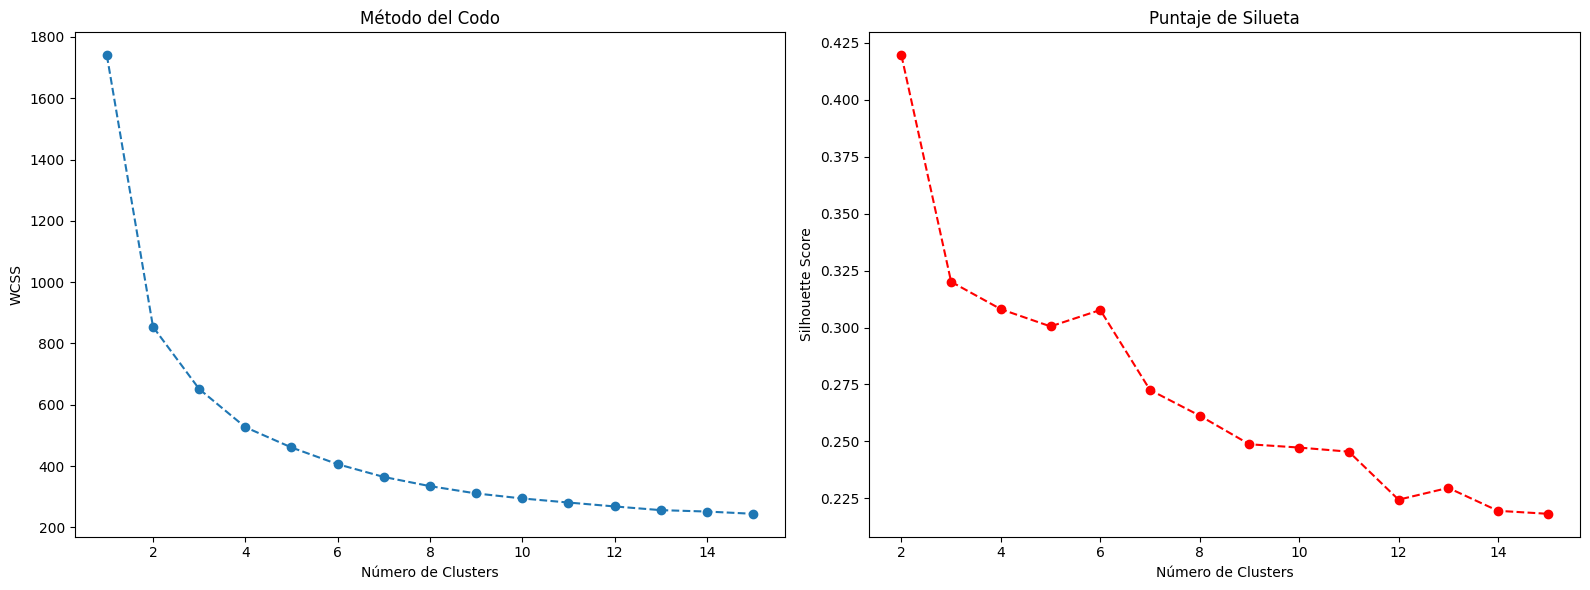

In [38]:
# 4. Método del codo para determinar el número óptimo de clusters
wcss = []  # List for the within-cluster sum of squares (WCSS)
silhouette_scores = []  # Para calcular el puntaje de silueta

for k in range(1, 16):  # Probar con diferentes valores de K (1 a 10)
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_)
    wcss.append(kmeans.inertia_)  # WCSS es la inercia
    if k > 1:  # Calcular silhouette score a partir de k=2
        silhouette_avg = silhouette_score(X_, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# 5. Graficar el método del codo
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), wcss, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# 6. Graficar el puntaje de silueta (opcional, pero útil para evaluar la calidad del cluster)
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), silhouette_scores, marker='o', color='r', linestyle='--')
plt.title('Puntaje de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

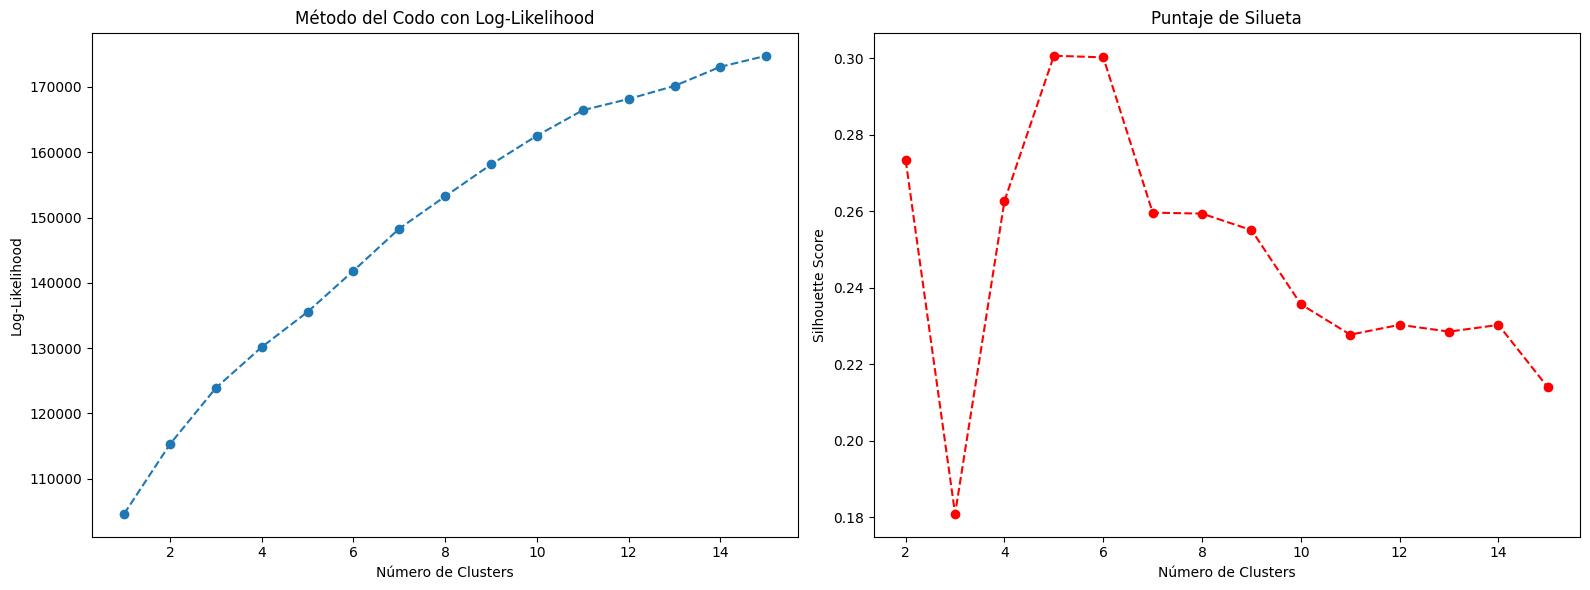

In [31]:
# Variables para almacenar resultados
log_likelihoods = []  # Log-likelihood para el método del codo
silhouette_scores = []  # Puntaje de silueta

# Probar con diferentes valores de K (número de clusters)
for k in range(1, 16):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_)
    log_likelihoods.append(gmm.score(X_) * len(X_))  # Log-likelihood total
    if k > 1:  # Calcular silhouette score a partir de k=2
        labels = gmm.predict(X_)
        silhouette_avg = silhouette_score(X_, labels)
        silhouette_scores.append(silhouette_avg)

# Graficar el método del codo con log-verosimilitud
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), log_likelihoods, marker='o', linestyle='--')
plt.title('Método del Codo con Log-Likelihood')
plt.xlabel('Número de Clusters')
plt.ylabel('Log-Likelihood')

# Graficar el puntaje de silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), silhouette_scores, marker='o', color='r', linestyle='--')
plt.title('Puntaje de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


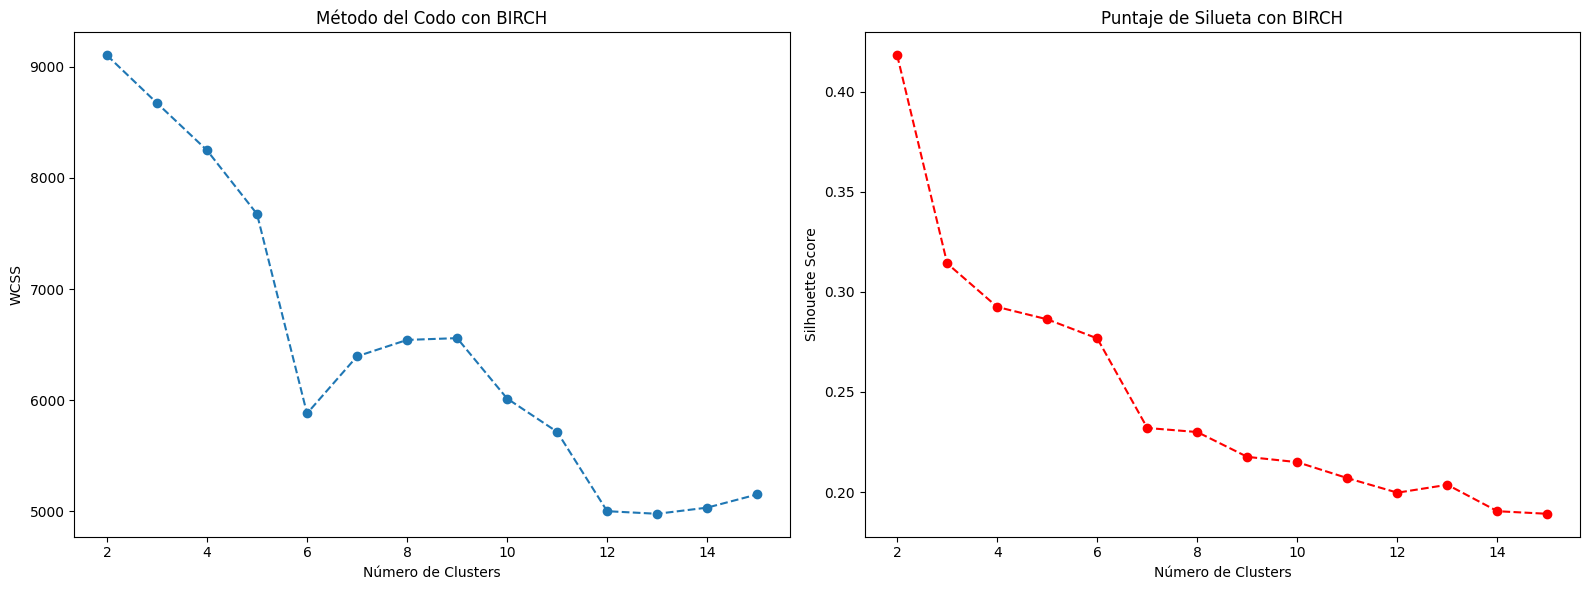

In [39]:
# Supongamos que 'X_' es el dataset preprocesado
wcss = []  # Lista para almacenar la suma de distancias dentro de los clusters
silhouette_scores = []  # Lista para los puntajes de silueta

# Probar con diferentes números de clusters
for k in range(2, 16):  # Birch necesita al menos 2 clusters para calcular scores
    birch = Birch(n_clusters=k, threshold=0.05)  # Ajusta el threshold si es necesario
    birch.fit(X_)
    labels = birch.labels_
    wcss.append(np.sum((X_ - birch.subcluster_centers_[labels])**2))  # Cálculo aproximado de WCSS
    silhouette_avg = silhouette_score(X_, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar los resultados
plt.figure(figsize=(16, 6))

# Método del Codo
plt.subplot(1, 2, 1)
plt.plot(range(2, 16), wcss, marker='o', linestyle='--')
plt.title('Método del Codo con BIRCH')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Puntaje de Silueta
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), silhouette_scores, marker='o', color='r', linestyle='--')
plt.title('Puntaje de Silueta con BIRCH')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

### Selección de clústers
Tras haber analizado las gráficas utilizando el método del codo, y observando el puntaje de silueta para cada número de clústers que se ha obtenido para KMeans, GaussianMixture y Birch, se ha decidido lo siguiente:

- Se utilizarán 6 agrupaciones para KMeans.
- Se utilizarán 6 agrupaciones para GaussianMixture, aunque 5 es una buena opción también.
- Se utilizarán 6 agrupaciones para BIRCH.

In [40]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_)
df_clientes["kmeans_cluster"] = kmeans.labels_
df_clientes_m["kmeans_cluster"] = kmeans.labels_

gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm.fit(X_)
gmm_labels = gmm.predict(X_)
df_clientes["gaussian_cluster"] = gmm_labels
df_clientes_m["gaussian_cluster"] = gmm_labels

birch = Birch(n_clusters=6, threshold=0.05)  # Ajusta el threshold si es necesario
birch.fit(X_)
df_clientes["birch_cluster"] = birch.labels_
df_clientes_m["birch_cluster"] = birch.labels_

df_clientes["Tipo"] = "Curva tipo"
df_clientes_m["Tipo"] = "Curva max"

In [41]:
df_clientes

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.275088,0.000000,0.813917,0.814028,0.806606,0.807950,...,0.817896,0.812761,0.824083,0.816269,0.814425,0.819875,3,1,2,Curva tipo
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.001030,0.824418,0.827557,0.825096,0.825745,...,0.828948,0.829196,0.826238,0.827933,0.826426,0.825682,3,1,2,Curva tipo
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.004700,0.617717,0.607220,0.589668,0.592406,...,0.626658,0.610887,0.614795,0.628457,0.640812,0.646614,3,1,2,Curva tipo
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.000000,0.256627,0.255630,0.248039,0.252266,...,0.313068,0.313104,0.321452,0.325761,0.325062,0.322732,1,5,4,Curva tipo
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.141778,0.145418,0.137683,0.139845,...,0.138576,0.151124,0.147873,0.160442,0.154047,0.151961,1,5,4,Curva tipo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,SIGMAPLAST,Desconocido,Desconocido,0000-00-00,7103.640000,0.000000,0.694344,0.696171,0.697165,0.698702,...,0.713191,0.712133,0.709766,0.711158,0.711458,0.714425,3,1,2,Curva tipo
384,SINTOFIL,Desconocido,Desconocido,0000-00-00,1479.480000,0.000000,0.514298,0.513626,0.512433,0.512842,...,0.571798,0.561596,0.559882,0.565276,0.566784,0.569124,3,1,2,Curva tipo
385,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,0000-00-00,407.452000,0.000000,0.509591,0.513217,0.543960,0.576485,...,0.435446,0.478534,0.503097,0.527862,0.525922,0.517069,2,2,0,Curva tipo
386,TEXTILES TEXSA,Desconocido,Desconocido,0000-00-00,774.860000,0.000000,0.566070,0.568113,0.566743,0.568308,...,0.586311,0.585818,0.592824,0.599960,0.601584,0.601834,3,1,2,Curva tipo


In [42]:
df_clientes_m

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,2023-10-12,0.275088,0.0,0.862187,0.849686,0.893362,0.862991,...,0.899812,0.914052,0.907269,0.883623,0.943573,0.886574,3,1,2,Curva max
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,2023-08-24,0.352398,0.00103,0.844897,0.838066,0.843189,0.842905,...,0.841197,0.858842,0.838066,0.834367,0.852866,0.833228,3,1,2,Curva max
2,RECIPLAST C.A.,E3811.00,10026628,2023-06-09,0.835514,0.0047,0.896742,0.910789,0.931013,0.888858,...,0.888131,0.928168,0.894945,0.887098,0.856103,0.941462,3,1,2,Curva max
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,2024-01-18,0.523054,0.0,0.6744,0.681722,0.689756,0.656754,...,0.007265,0.006883,0.007074,0.007456,0.007074,0.006883,1,5,4,Curva max
4,Desconocido,Desconocido,10033889,2023-06-16,1.577123,0.006601,0.390944,0.403446,0.372298,0.299738,...,0.100288,0.064165,0.06609,0.224087,0.549842,0.371203,1,5,4,Curva max
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.64,0.0,0.837834,0.83859,0.816793,0.847409,...,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164,3,1,2,Curva max
384,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.48,0.0,0.897929,0.870149,0.886222,0.933214,...,0.909582,0.92267,0.913897,0.854695,0.900084,0.931208,3,1,2,Curva max
385,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452,0.0,0.4149,0.482894,0.601808,0.607964,...,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556,2,2,0,Curva max
386,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.86,0.0,0.736179,0.745167,0.742498,0.754046,...,0.79903,0.715995,0.849222,0.866753,0.802865,0.819957,3,1,2,Curva max


In [43]:
df_concat = pd.concat([df_clientes, df_clientes_m])

In [44]:
df_concat

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.275088,0.0,0.813917,0.814028,0.806606,0.80795,...,0.817896,0.812761,0.824083,0.816269,0.814425,0.819875,3,1,2,Curva tipo
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.00103,0.824418,0.827557,0.825096,0.825745,...,0.828948,0.829196,0.826238,0.827933,0.826426,0.825682,3,1,2,Curva tipo
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.0047,0.617717,0.60722,0.589668,0.592406,...,0.626658,0.610887,0.614795,0.628457,0.640812,0.646614,3,1,2,Curva tipo
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.0,0.256627,0.25563,0.248039,0.252266,...,0.313068,0.313104,0.321452,0.325761,0.325062,0.322732,1,5,4,Curva tipo
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.141778,0.145418,0.137683,0.139845,...,0.138576,0.151124,0.147873,0.160442,0.154047,0.151961,1,5,4,Curva tipo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.64,0.0,0.837834,0.83859,0.816793,0.847409,...,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164,3,1,2,Curva max
384,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.48,0.0,0.897929,0.870149,0.886222,0.933214,...,0.909582,0.92267,0.913897,0.854695,0.900084,0.931208,3,1,2,Curva max
385,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452,0.0,0.4149,0.482894,0.601808,0.607964,...,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556,2,2,0,Curva max
386,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.86,0.0,0.736179,0.745167,0.742498,0.754046,...,0.79903,0.715995,0.849222,0.866753,0.802865,0.819957,3,1,2,Curva max


In [45]:
df_concat.to_csv("archivos_salida_script/clientes_clasificados_por_curva_tipo.csv", index=False)

#### Obtención de los entregables

Una vez tenemos cada clientes clasificados, tanto para k=4 como para k=8, debemos obtener en una carpeta separada por cluster, y por cliente, los siguientes entregables:
- Curva tipo en formato .png
- Curva del día de demanda máxima en .png
- Datos de la curva tipo en un .csv
- Datos de la curva del día de demanda máxima en un .csv
- Potencia aparente máxima y mínima en un .txt

Nota: El último archivo es necesario debido a que los datos están normalizados con un escalador max-min, y con estos valores podemos obtener el valor original de potencia para ese cliente.

Adicionalmente, se ha pedido los siguientes entregables por cada agrupación:
- Una curva tipo por cada agrupación de clientes
- Los datos de dicha curva tipo en un .csv

In [46]:
df_clientes_clasificados = pd.read_csv("archivos_salida_script/clientes_clasificados_por_curva_tipo.csv")
df_clientes_clasificados["CODIGOCLIE"] = df_clientes_clasificados["CODIGOCLIE"].astype("string")
df_clientes_clasificados["Nombre"] = df_clientes_clasificados["Nombre"].astype("string")
df_clientes_clasificados

,Nombre,CIIU,CODIGOCLIE,Fecha,Max_potencia_ap,Min_potencia_ap,00:00,00:15,00:30,00:45,...,22:30,22:45,23:00,23:15,23:30,23:45,kmeans_cluster,gaussian_cluster,birch_cluster,Tipo
0,MOLPACK ECUADOR ECUAMOLPACK S.A.,C1702.02,10016608,0000-00-00,0.275088,0.000000,0.813917,0.814028,0.806606,0.807950,...,0.817896,0.812761,0.824083,0.816269,0.814425,0.819875,3,1,2,Curva tipo
1,CIRION TECHNOLOGIES ECUADOR S.A.,J6190.02,10020880,0000-00-00,0.352398,0.001030,0.824418,0.827557,0.825096,0.825745,...,0.828948,0.829196,0.826238,0.827933,0.826426,0.825682,3,1,2,Curva tipo
2,RECIPLAST C.A.,E3811.00,10026628,0000-00-00,0.835514,0.004700,0.617717,0.607220,0.589668,0.592406,...,0.626658,0.610887,0.614795,0.628457,0.640812,0.646614,3,1,2,Curva tipo
3,PQA PRODUCTORES QUIMICOS ECUATORIANOS S.A.,G4669.21,10031377,0000-00-00,0.523054,0.000000,0.256627,0.255630,0.248039,0.252266,...,0.313068,0.313104,0.321452,0.325761,0.325062,0.322732,1,5,4,Curva tipo
4,Desconocido,Desconocido,10033889,0000-00-00,1.577123,0.006601,0.141778,0.145418,0.137683,0.139845,...,0.138576,0.151124,0.147873,0.160442,0.154047,0.151961,1,5,4,Curva tipo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,SIGMAPLAST,Desconocido,Desconocido,2023-12-15,7103.640000,0.000000,0.837834,0.838590,0.816793,0.847409,...,0.814304,0.788631,0.812722,0.827741,0.839684,0.890164,3,1,2,Curva max
772,SINTOFIL,Desconocido,Desconocido,2023-02-14,1479.480000,0.000000,0.897929,0.870149,0.886222,0.933214,...,0.909582,0.922670,0.913897,0.854695,0.900084,0.931208,3,1,2,Curva max
773,SOCIEDAD INDUSTRIAL RELI CYRANO,Desconocido,Desconocido,2023-04-28,407.452000,0.000000,0.414900,0.482894,0.601808,0.607964,...,0.585581,0.382043,0.610948,0.502813,0.560076,0.450556,2,2,0,Curva max
774,TEXTILES TEXSA,Desconocido,Desconocido,2023-05-10,774.860000,0.000000,0.736179,0.745167,0.742498,0.754046,...,0.799030,0.715995,0.849222,0.866753,0.802865,0.819957,3,1,2,Curva max


In [47]:
def graficar_curva_tipo(columnas, valores, cod_cli, path):

    # Graficar
    plt.figure(figsize=(16, 6))
    plt.plot(columnas, valores, marker='o', color='b', linestyle='-', label='Potencia Aparente Escalada')
    plt.title(f'Curva tipo cliente {cod_cli.split(".")[0]}')
    plt.xlabel('Hora')
    plt.ylabel('Potencia Aparente Escalada')
    plt.grid(True)
    #plt.legend()
    plt.xticks(columnas[::2], rotation=45)  # Si las horas se ven muy amontonadas, rota las etiquetas del eje X
    plt.tight_layout()  # Ajusta para evitar recortes en las etiquetas
    
    #plt.show()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    plt.savefig(f"{path}/curva_tipo_{cod_cli.split('.')[0]}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # No se muestra la gráfica, solo se guarda
    plt.close()  # Esto cierra la figura después de guardarla para liberar recursos

def graficar_dia_max_demanda(columnas, valores, cod_cli, path, fecha):

    # Graficar la potencia aparente escalada a lo largo del día
    plt.figure(figsize=(16, 6))
    plt.plot(columnas, valores, marker='o', color='r', linestyle='-', label=f'Potencia Aparente Escalada')
    plt.title(f'Curva del día de demanda máxima {fecha} para cliente {cod_cli.split(".")[0]}')
    plt.xlabel('Hora')
    plt.ylabel('Potencia Aparente Escalada')
    plt.grid(True)
    plt.legend()
    plt.xticks(columnas[::2], rotation=45)
    plt.tight_layout()
    
    #plt.show()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    plt.savefig(f"{path}/curva_dia_demanda_max_{cod_cli.split('.')[0]}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # No se muestra la gráfica, solo se guarda
    plt.close()  # Esto cierra la figura después de guardarla para liberar recursos

In [50]:
# Primero hagamos la ejecución para KMeans:

clusters = df_clientes_clasificados["kmeans_cluster"].unique()
carpeta_guardar = r"agrupaciones/kmeans_cluster"
cols = df_clientes_clasificados.columns[6:-4].values

print(cols)
print(clusters)

['00:00' '00:15' '00:30' '00:45' '01:00' '01:15' '01:30' '01:45' '02:00'
 '02:15' '02:30' '02:45' '03:00' '03:15' '03:30' '03:45' '04:00' '04:15'
 '04:30' '04:45' '05:00' '05:15' '05:30' '05:45' '06:00' '06:15' '06:30'
 '06:45' '07:00' '07:15' '07:30' '07:45' '08:00' '08:15' '08:30' '08:45'
 '09:00' '09:15' '09:30' '09:45' '10:00' '10:15' '10:30' '10:45' '11:00'
 '11:15' '11:30' '11:45' '12:00' '12:15' '12:30' '12:45' '13:00' '13:15'
 '13:30' '13:45' '14:00' '14:15' '14:30' '14:45' '15:00' '15:15' '15:30'
 '15:45' '16:00' '16:15' '16:30' '16:45' '17:00' '17:15' '17:30' '17:45'
 '18:00' '18:15' '18:30' '18:45' '19:00' '19:15' '19:30' '19:45' '20:00'
 '20:15' '20:30' '20:45' '21:00' '21:15' '21:30' '21:45' '22:00' '22:15'
 '22:30' '22:45' '23:00' '23:15' '23:30' '23:45']
[3 1 2 5 4 0]


In [55]:
for k in tqdm(clusters, desc="Obteniendo entregables para KMeans"):
    clientes_agrupados = df_clientes_clasificados[df_clientes_clasificados["kmeans_cluster"]==k].copy()

    for index, row in clientes_agrupados.iterrows():
        cod_cli = row["CODIGOCLIE"].strip()

        if cod_cli == "Desconocido":
            cod_cli = row["Nombre"].strip()
            
        #print(f"Iterando sobre cliente {cod_cli}")
        
        path = rf"{carpeta_guardar}/{k}/{cod_cli}"
        os.makedirs(path, exist_ok=True)

        if row["Tipo"] == "Curva tipo":
            valores = row[6:-4].values
            
            #Guardar un .csv con los datos de la curva tipo
            #print(f"{len(valores)}     {len(cols)}")
            df_datos_ctipo = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_ctipo.to_csv(rf"{path}/datos_curva_tipo.csv", index=False)

            #Guardar la img de la curva tipo
            graficar_curva_tipo(cols, valores, cod_cli, path)

            #Guardar .txt con potencia aparente máxima y mínima
            open(rf'{path}\archivo.txt', 'w').write(f'Pot_aparente_max: {row["Max_potencia_ap"]}\nPot_aparente_min: {row["Min_potencia_ap"]}')

            #Liberar memoria
            del df_datos_ctipo
            gc.collect()
        elif row["Tipo"] == "Curva max":
            valores = row[6:-4].values

            #Guardar un .csv con los datos de la curva del dia de demanda max
            df_datos_cmax = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_cmax.to_csv(rf"{path}/datos_dia_demanda_max.csv", index=False)

            #Guardar la img de curva del dia de demanda max
            graficar_dia_max_demanda(cols, valores, cod_cli, path, row["Fecha"])

            #Liberar memoria
            del df_datos_cmax
            gc.collect()

    del clientes_agrupados
    gc.collect()

Obteniendo entregables para KMeans: 100%|██████████| 6/6 [32:48<00:00, 328.13s/it]


In [56]:
clusters = df_clientes_clasificados["gaussian_cluster"].unique()
carpeta_guardar = r"agrupaciones/gaussian_cluster"

for k in tqdm(clusters, desc="Obteniendo entregables para GaussianMixture"):
    clientes_agrupados = df_clientes_clasificados[df_clientes_clasificados["gaussian_cluster"]==k].copy()

    for index, row in clientes_agrupados.iterrows():
        cod_cli = row["CODIGOCLIE"].strip()

        if cod_cli == "Desconocido":
            cod_cli = row["Nombre"].strip()
            
        #print(f"Iterando sobre cliente {cod_cli}")
        
        path = rf"{carpeta_guardar}/{k}/{cod_cli}"
        os.makedirs(path, exist_ok=True)

        if row["Tipo"] == "Curva tipo":
            valores = row[6:-4].values
            
            #Guardar un .csv con los datos de la curva tipo
            #print(f"{len(valores)}     {len(cols)}")
            df_datos_ctipo = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_ctipo.to_csv(rf"{path}/datos_curva_tipo.csv", index=False)

            #Guardar la img de la curva tipo
            graficar_curva_tipo(cols, valores, cod_cli, path)

            #Guardar .txt con potencia aparente máxima y mínima
            open(rf'{path}\archivo.txt', 'w').write(f'Pot_aparente_max: {row["Max_potencia_ap"]}\nPot_aparente_min: {row["Min_potencia_ap"]}')

            #Liberar memoria
            del df_datos_ctipo
            gc.collect()
        elif row["Tipo"] == "Curva max":
            valores = row[6:-4].values

            #Guardar un .csv con los datos de la curva del dia de demanda max
            df_datos_cmax = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_cmax.to_csv(rf"{path}/datos_dia_demanda_max.csv", index=False)

            #Guardar la img de curva del dia de demanda max
            graficar_dia_max_demanda(cols, valores, cod_cli, path, row["Fecha"])

            #Liberar memoria
            del df_datos_cmax
            gc.collect()

    del clientes_agrupados
    gc.collect()

Obteniendo entregables para GaussianMixture: 100%|██████████| 6/6 [48:47<00:00, 487.91s/it]   


In [58]:
clusters = df_clientes_clasificados["birch_cluster"].unique()
carpeta_guardar = r"agrupaciones/birch_cluster"

for k in tqdm(clusters, desc="Obteniendo entregables para BIRCH"):
    clientes_agrupados = df_clientes_clasificados[df_clientes_clasificados["birch_cluster"]==k].copy()

    for index, row in clientes_agrupados.iterrows():
        cod_cli = row["CODIGOCLIE"].strip()

        if cod_cli == "Desconocido":
            cod_cli = row["Nombre"].strip()
            
        #print(f"Iterando sobre cliente {cod_cli}")
        
        path = rf"{carpeta_guardar}/{k}/{cod_cli}"
        os.makedirs(path, exist_ok=True)

        if row["Tipo"] == "Curva tipo":
            valores = row[6:-4].values
            
            #Guardar un .csv con los datos de la curva tipo
            #print(f"{len(valores)}     {len(cols)}")
            df_datos_ctipo = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_ctipo.to_csv(rf"{path}/datos_curva_tipo.csv", index=False)

            #Guardar la img de la curva tipo
            graficar_curva_tipo(cols, valores, cod_cli, path)

            #Guardar .txt con potencia aparente máxima y mínima
            open(rf'{path}\archivo.txt', 'w').write(f'Pot_aparente_max: {row["Max_potencia_ap"]}\nPot_aparente_min: {row["Min_potencia_ap"]}')

            #Liberar memoria
            del df_datos_ctipo
            gc.collect()
        elif row["Tipo"] == "Curva max":
            valores = row[6:-4].values

            #Guardar un .csv con los datos de la curva del dia de demanda max
            df_datos_cmax = pd.DataFrame(np.array([cols, valores]).T, columns=["Hora", "Potencia aparente escalada"])
            df_datos_cmax.to_csv(rf"{path}/datos_dia_demanda_max.csv", index=False)

            #Guardar la img de curva del dia de demanda max
            graficar_dia_max_demanda(cols, valores, cod_cli, path, row["Fecha"])

            #Liberar memoria
            del df_datos_cmax
            gc.collect()

    del clientes_agrupados
    gc.collect()

Obteniendo entregables para BIRCH: 100%|██████████| 6/6 [27:24<00:00, 274.08s/it]


#### Finalmente, obtener curva tipo para cada clúster obtenido

In [59]:
def obtener_curva_tipo_cluster(df_datos_cluster, path, alg_agrupacion, n_cluster):
    df_datos_cluster["Hora"] = df_datos_cluster["Hora"].astype("string")

    df_grouped = df_datos_cluster.groupby("Hora")["Potencia aparente escalada"].apply(func="mean").reset_index(drop=False)

    # Graficar
    plt.figure(figsize=(16, 6))
    plt.plot(df_grouped["Hora"], df_grouped["Potencia aparente escalada"], marker='o', 
                                                                           color='y', 
                                                                           linestyle='-', 
                                                                           label='Potencia Aparente Escalada')
    plt.title(rf'Curva tipo para agrupación #{n_cluster} - {alg_agrupacion}')
    plt.xlabel('Hora')
    plt.ylabel('Potencia Aparente Escalada')
    plt.grid(True)
    #plt.legend()
    plt.xticks(df_grouped.index[::2], rotation=45)  # Si las horas se ven muy amontonadas, rota las etiquetas del eje X
    plt.tight_layout()  # Ajusta para evitar recortes en las etiquetas
    
    #plt.show()

    # Guardar la gráfica en un archivo (por ejemplo, como archivo PNG)
    plt.savefig(f"{path}/curva_tipo_cluster{n_cluster}_{alg_agrupacion}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.
    
    # No se muestra la gráfica, solo se guarda
    plt.close()  # Esto cierra la figura después de guardarla para liberar recursos

    df_grouped.to_csv(rf"{path}/datos_curva_tipo_cluster{n_cluster}_{alg_agrupacion}.csv", index=False)

In [61]:
carpeta_agrupaciones = "agrupaciones"

subcarpetas = list(os.scandir(carpeta_agrupaciones))

# Iterar sobre subcarpetas kmeans, gaussian y birch
for subcarpeta in tqdm(subcarpetas, desc="Obteniendo gráficos y datos de curva tipo para las agrupaciones"):
    agrupaciones = list(os.scandir(rf"agrupaciones/{subcarpeta.name}"))

    # Iterar sobre cada carpeta de agrupacion
    for agrupacion in agrupaciones:
        df_datos_agrupacion = pd.DataFrame()
        clientes_agrupacion = list(os.scandir(rf"agrupaciones/{subcarpeta.name}/{agrupacion.name}"))

        # Iterar sobre cada cliente encontrado dentro de esa agrupacion
        for cliente in clientes_agrupacion:
            # Construir path para leer archivos con los datos de la curva tipo
            df_datos_cliente = pd.read_csv(rf"agrupaciones/{subcarpeta.name}/{agrupacion.name}/{cliente.name}/datos_curva_tipo.csv")

            df_datos_agrupacion = pd.concat([df_datos_agrupacion, df_datos_cliente])
        
        # Obtener la gráfica y los datos de la curva tipo de ese clúster para ese algoritmo
        obtener_curva_tipo_cluster(df_datos_agrupacion, rf"agrupaciones/{subcarpeta.name}/{agrupacion.name}", subcarpeta.name.split("_")[0],agrupacion.name)

Obteniendo gráficos y datos de curva tipo para las agrupaciones: 100%|██████████| 3/3 [00:25<00:00,  8.56s/it]
